In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.under_sampling import NearMiss
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel("./energy_demand.xlsx")
df.head()

,Date,Hour,load,T
0,2012-01-01,0,2872.0,30.666667
1,2012-01-01,1,2698.0,32.000000
2,2012-01-01,2,2558.0,32.666667
3,2012-01-01,3,2444.0,30.000000
4,2012-01-01,4,2402.0,31.000000


In [3]:
df.tail()

,Date,Hour,load,T
26300,2014-12-31,20,4012.0,18.000000
26301,2014-12-31,21,3856.0,16.666667
26302,2014-12-31,22,3671.0,17.000000
26303,2014-12-31,23,3499.0,15.333333
26304,2014-12-31,24,3345.0,15.333333


In [4]:
len(df.columns)

4

In [5]:
df.columns
df.dtypes

Date    datetime64[ns]
Hour             int64
load           float64
T              float64
dtype: object

In [6]:
df.shape

(26305, 4)

In [7]:
df.size

105220

In [8]:
df.min()

Date    2012-01-01 00:00:00
Hour                      0
load                 1979.0
T                -13.666667
dtype: object

In [9]:
df.max()

Date    2014-12-31 00:00:00
Hour                     24
load                 5224.0
T                      95.0
dtype: object

In [10]:
df.describe()

,Date,Hour,load,T
count,26305,26305.000000,26305.000000,26305.000000
mean,2013-07-01 11:30:01.710701312,12.499525,3303.752785,47.764988
min,2012-01-01 00:00:00,0.000000,1979.000000,-13.666667
25%,2012-09-30 00:00:00,6.000000,2867.000000,32.666667
50%,2013-07-01 00:00:00,12.000000,3364.000000,48.333333
75%,2014-04-01 00:00:00,18.000000,3690.000000,63.666667
max,2014-12-31 00:00:00,24.000000,5224.000000,95.000000
std,NaN,6.922616,564.574798,19.338062


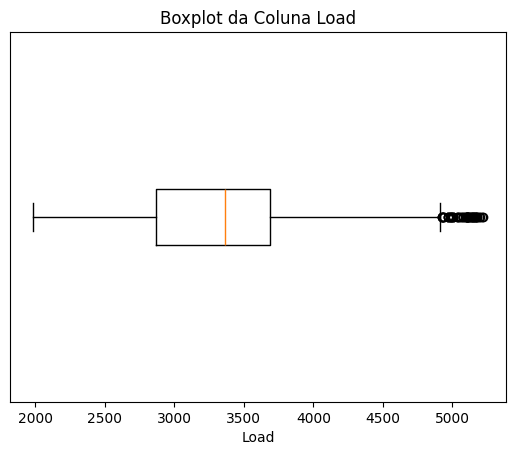

In [11]:
plt.boxplot(df['load'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Load')
plt.title('Boxplot da Coluna Load')
plt.yticks([])

# Mostra o boxplot
plt.show()

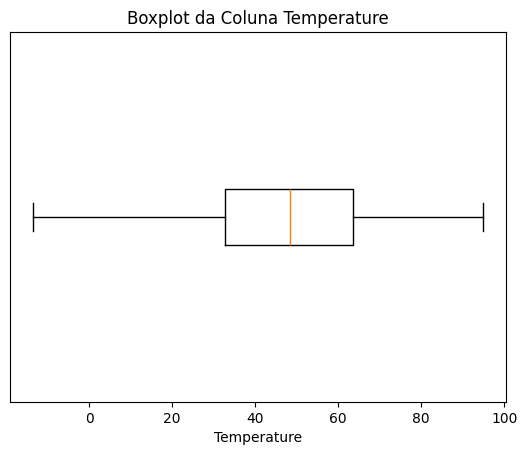

In [12]:
plt.boxplot(df['T'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Temperature')
plt.title('Boxplot da Coluna Temperature')
plt.yticks([])

# Mostra o boxplot
plt.show()

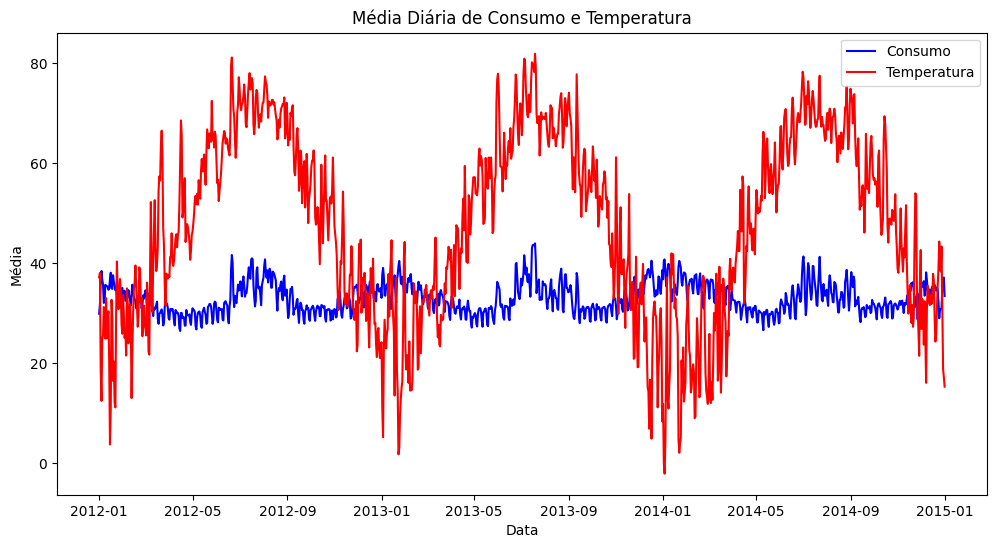

In [13]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Hour'] = pd.to_timedelta(df['Hour'], unit='h')

# Criar a coluna 'DateTime' combinando 'Date' e 'Hour'
df['DateTime'] = df['Date'] + df['Hour']

# Remover 'Date' e 'Hour' se necessário
df.drop(['Date', 'Hour'], axis=1, inplace=True)

# Configurar 'DateTime' como índice
df.set_index('DateTime', inplace=True)

# Agrupar por dia e calcular a média
daily_data = df.resample('D').mean()
daily_data['load'] = daily_data['load'] / 100

# Plotar o gráfico de dupla entrada
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_data.index, y=daily_data['load'], label='Consumo', color='blue')
sns.lineplot(x=daily_data.index, y=daily_data['T'], label='Temperatura', color='red')

plt.title('Média Diária de Consumo e Temperatura')
plt.xlabel('Data')
plt.ylabel('Média')
plt.legend()
plt.show()

In [14]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


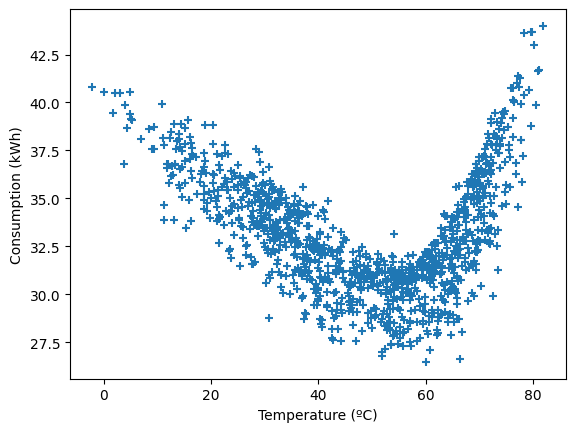

In [15]:
plt.scatter(daily_data['T'], daily_data['load'], marker='+')

plt.xlabel('Temperature (ºC)')
plt.ylabel('Consumption (kWh)')
plt.show()

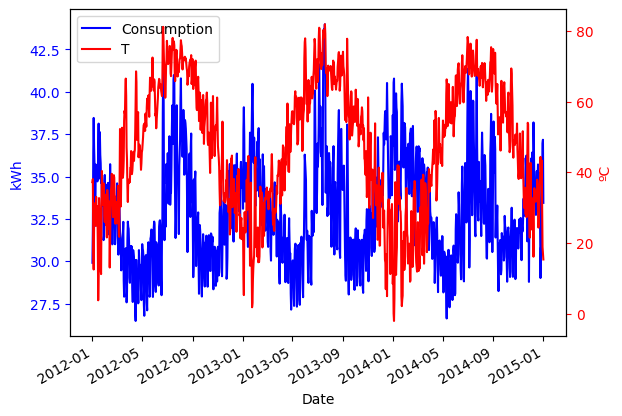

In [16]:
fig, ax1 = plt.subplots()

ax1.plot(daily_data.index, daily_data['load'], 'b', label='Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('kWh', color='b')
ax1.tick_params('y', colors='b')

fig.autofmt_xdate()

ax2 = ax1.twinx()

ax2.plot(daily_data.index, daily_data['T'], 'r', label='T')
ax2.set_ylabel('ºC', color='r')
ax2.tick_params('y', colors='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

plt.show()


In [17]:
df1=df
daily_data = df1.resample('24h').mean()
daily_data.head()


,load,T
DateTime,,
2012-01-01,2991.458333,37.208333
2012-01-02,3188.791667,38.083333
2012-01-03,3645.375000,18.291667
2012-01-04,3846.041667,12.486111
2012-01-05,3672.458333,25.000000


In [18]:
df.isna().sum()


load    0
T       0
dtype: int64

In [19]:
df.isnull().sum()

load    0
T       0
dtype: int64

In [20]:
df

,load,T
DateTime,,
2012-01-01 00:00:00,2872.0,30.666667
2012-01-01 01:00:00,2698.0,32.000000
2012-01-01 02:00:00,2558.0,32.666667
2012-01-01 03:00:00,2444.0,30.000000
2012-01-01 04:00:00,2402.0,31.000000
...,...,...
2014-12-31 20:00:00,4012.0,18.000000
2014-12-31 21:00:00,3856.0,16.666667
2014-12-31 22:00:00,3671.0,17.000000


In [21]:
load_series = df['load']

# Aplicar o teste ADF
result = adfuller(load_series)

# Exibir os resultados
print('ADF Statistic:', result[0])
print(f'p-value: {result[1]:.3e}')  # Formatando o p-value para notação científica com 3 casas decimais
print('Critical Values:', result[4])
#p-value mais baixo que 0.05 significa que se rejeita a hipotese nula, ou seja, admite-se que a série é estacionária

ADF Statistic: -10.406281746483788
p-value: 1.853e-18
Critical Values: {'1%': -3.430599093104556, '5%': -2.861650091842415, '10%': -2.566828598628419}


In [22]:
df['hourofday'] = df.index.hour
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week
df['days_in_month'] = df.index.days_in_month
df['isWeekend'] = df.index.weekday // 5
df['isWeekend'] = df['isWeekend'].map({0: 'No', 1: 'Yes'})
df['dayoftheweek'] = df.index.dayofweek


In [23]:
df

,load,T,hourofday,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_in_month,isWeekend,dayoftheweek
DateTime,,,,,,,,,,,,
2012-01-01 00:00:00,2872.0,30.666667,0,1,1,2012,1,1,52,31,Yes,6
2012-01-01 01:00:00,2698.0,32.000000,1,1,1,2012,1,1,52,31,Yes,6
2012-01-01 02:00:00,2558.0,32.666667,2,1,1,2012,1,1,52,31,Yes,6
2012-01-01 03:00:00,2444.0,30.000000,3,1,1,2012,1,1,52,31,Yes,6
2012-01-01 04:00:00,2402.0,31.000000,4,1,1,2012,1,1,52,31,Yes,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 20:00:00,4012.0,18.000000,20,4,12,2014,365,31,1,31,No,2
2014-12-31 21:00:00,3856.0,16.666667,21,4,12,2014,365,31,1,31,No,2
2014-12-31 22:00:00,3671.0,17.000000,22,4,12,2014,365,31,1,31,No,2


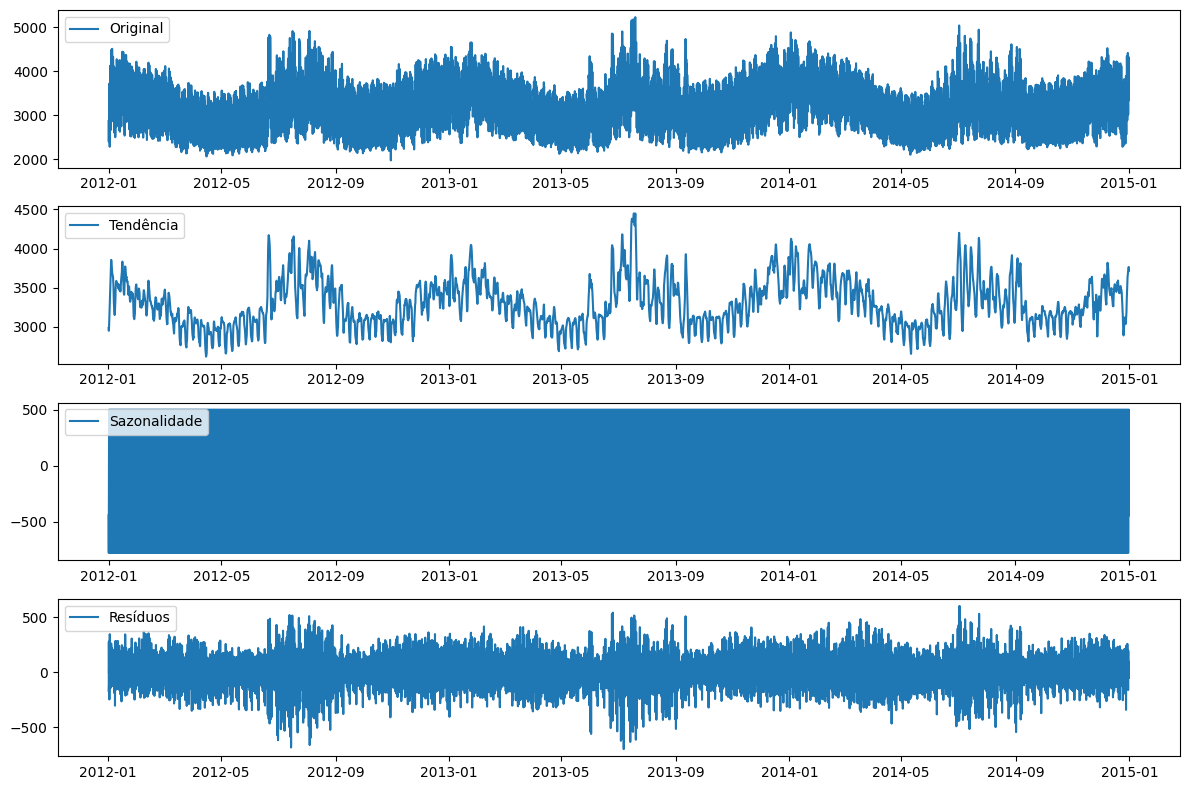

In [24]:

# Supondo que 'df' seja seu DataFrame com uma coluna chamada 'load'
load_series = df['load']

# Realizar a decomposição
result = seasonal_decompose(load_series, model='additive', period=24)  # O período aqui é assumido como 24 para dados horários

# Extrair as componentes
trend = result.trend
seasonal = result.seasonal
residuals = result.resid

# Plotar as componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(load_series, label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residuals, label='Resíduos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

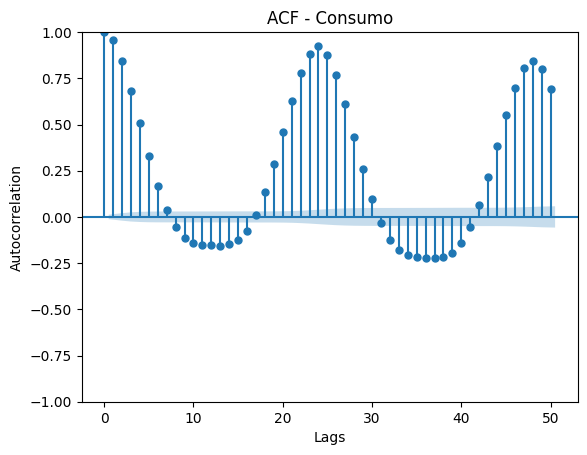

<Figure size 1200x600 with 0 Axes>

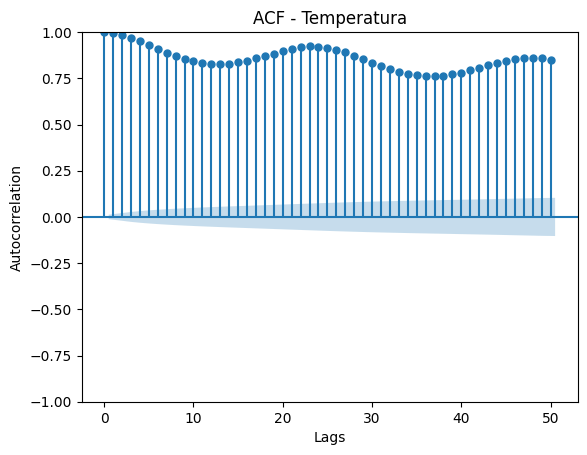

In [25]:

consumo_series = df['load']
temperatura_series = df['T']

plt.figure(figsize=(12, 6))
plot_acf(consumo_series, lags=50, title='ACF - Consumo')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(temperatura_series, lags=50, title='ACF - Temperatura')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()
#correlaçao existe até 10 dias


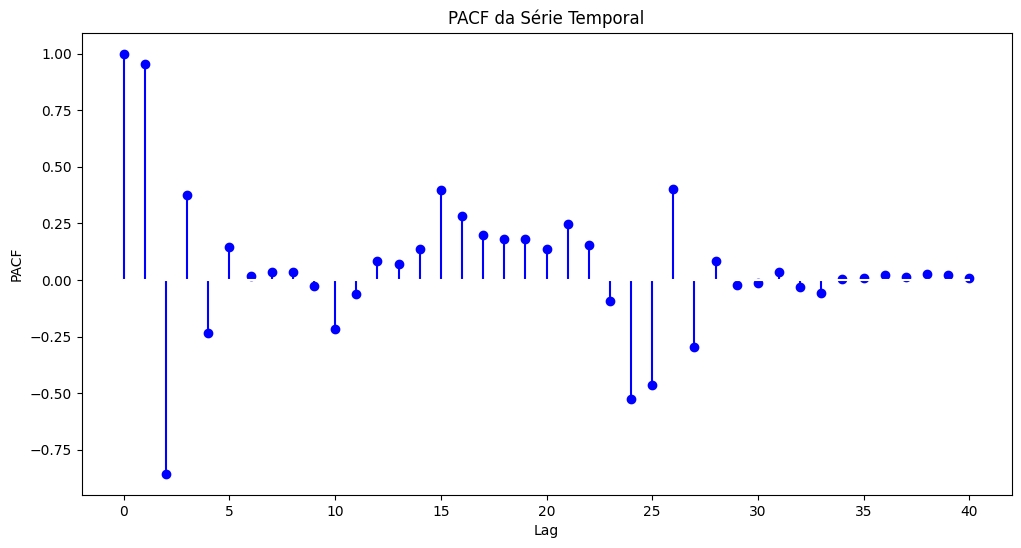

In [26]:
pacf_values, pacf_conf_int = sm.tsa.pacf(df['load'], nlags=40, alpha=0.05)

# Plotar a PACF
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_values)), pacf_values, linefmt='b-', markerfmt='bo', basefmt='w-')
plt.title('PACF da Série Temporal')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [27]:
# Criar cópias atrasadas das séries temporais
lag_consumo = 1  # Defina o lag desejado
lag_temperatura = 0  # Pode ajustar conforme necessário

consumo_shifted = consumo_series.shift(lag_consumo)
temperatura_shifted = temperatura_series.shift(lag_temperatura)

# Calcular a correlação entre as séries temporais atrasadas
correlation = consumo_shifted.corr(temperatura_shifted)

print(f"Correlação entre Consumo (lag={lag_consumo}) e Temperatura (lag={lag_temperatura}): {correlation}")


Correlação entre Consumo (lag=1) e Temperatura (lag=0): 0.08164031232672776


In [28]:
d = 0
D = 0
s = 24

def evaluate_sarima(order, seasonal_order, data):
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        aic = results.aic
        return aic
    except:
        return float('inf')  # Return a large value for combinations that fail

def grid_search_sarima(data, p_values, d, q_values, P_values, D, Q_values, s):
    best_aic = float('inf')
    best_params = None

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(p_values,  q_values, P_values, Q_values))

    for param_set in param_combinations:
        order = (param_set[0], d, param_set[1])
        seasonal_order = (param_set[2], D, param_set[3], s)
        print(param_set)
        aic = evaluate_sarima(order, seasonal_order, data)

        if aic < best_aic:
            best_aic = aic
            best_params = param_set

    return best_params, best_aic

# Example usage:
# Define the ranges for your parameters
p_values = range(2, 4)
q_values = range(2, 4)
P_values = range(2, 4)
Q_values = range(2, 4)

# Perform grid search
best_params, best_aic = grid_search_sarima(df['load'], p_values, d, q_values, P_values, D, Q_values, s)

print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(2, 2, 2, 2)
(2, 2, 2, 3)
(2, 2, 3, 2)
(2, 2, 3, 3)
(2, 3, 2, 2)
(2, 3, 2, 3)
(2, 3, 3, 2)
(2, 3, 3, 3)
(3, 2, 2, 2)
(3, 2, 2, 3)
(3, 2, 3, 2)
(3, 2, 3, 3)
(3, 3, 2, 2)
(3, 3, 2, 3)
(3, 3, 3, 2)
(3, 3, 3, 3)
Best Parameters: (3, 3, 2, 3)
Best AIC: 605.0876322742924


In [29]:
p = 2
d = 0
q = 3
P = 2
D = 0
Q = 2
s = 24

# Assuming scaled_data and df are already defined

p, d, q = 3, 0, 3
P, D, Q, s = 2, 0, 3, 24

df_load = df['load']
train_size = len(df_load) - 300
train, test = df_load[:train_size], df_load[train_size:]

def rolling_forecast_sarima(df, train_len, horizon, window):
    total_len = train_len + horizon
    pred_SARIMA = []
    
    # Initial model
    model = SARIMAX(df[:train_len], order=(p, d, q), seasonal_order=(P, D, Q, s))
    res = model.fit(disp=False)

    for i in range(train_len, total_len, window):
        # Update model with new data
        model = SARIMAX(df[:i], order=(p, d, q), seasonal_order=(P, D, Q, s))
        res = model.filter(res.params)

        # Forecast
        predictions = res.get_prediction(end=i + window - 1)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_SARIMA.extend(oos_pred)
    
    return pred_SARIMA

pred_SARIMA = rolling_forecast_sarima(df_load, len(train), len(test), 1)

# Plot the training data, test data, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Test Data', color='orange')
plt.plot(test.index, pred_SARIMA, label='SARIMA Forecast', color='green')

plt.title('SARIMA Model Forecasting')
plt.xlabel('Time')
plt.ylabel('LOAD')
plt.legend()
plt.show()

KeyboardInterrupt: 